In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import torch
import pylops
import pyproximal
import astra
import h5py

from scipy.sparse.linalg import lsqr

np.random.seed(1)

astra.test()

No GPU support available
Testing basic CPU 2D functionality... Ok


In [2]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

## Deep Learning in Scientific Inverse Problems
### Matteo Ravasi, Assistant Professor - KAUST

<font color='orange'>Data Assimilation Summer School 2023, 26/27 July 2023</font>

<img src="../figs/Dragons1.png" width="600" align="center">

<img src="../figs/IP_DL.png" width="800" align="center">

<img src="../figs/IP_DL1.png" width="800" align="center">

## Notation

**Inverse Problems**
- $\mathbf{m}$: model. Quantity that we are interested to know and we think affeccts the data - human organs, rock properties, pressure, atmosferic pressure, ...
- $\mathbf{d}$: observed data. Quantity that we can physicially measure - CT scan, seismic data, production data, precipitation, ...
- $\mathbf{G}$ (or $g()$): modelling operator. Set of equations that we think can explain the data by nonlinear/linear combination of model parameters - Radon, seismic convolution model, Navier-stoke (or any other PDE)...

**Deep Learning**
- $\mathbf{d}^{(i)}, \mathbf{m}^{(i)} \; i=1,..., N_{train}$: training data. Pairs of data and model that are linked via the modelling operator $\mathbf{G}$. Can be directly acquired with an expensive experiment (usually $\mathbf{m}$ cannot be acquired!) or numerically generated. Compactly represented as $\mathbf{D}$ and $\mathbf{M}$ with training samples over columns.
- $f_\theta$: parametric model (e.g., Neural network), where $\theta$ are the parameters to be learned.

## Inverse problems

$$
\underset{\mathbf{m}} {\mathrm{argmin}} \; \mathcal{L}(\mathbf{d}, \mathbf{Gm}) + \mathcal{R}(\mathbf{m})
$$

where:

- $\mathcal{L}$: loss (e.g., $||.||_2^2$)
- $\mathcal{R}$: regularization

## Deep Learning

$$
\underset{\theta} {\mathrm{argmin}} \; \mathcal{L}(\mathbf{M}, \mathbf{D}) + \mathcal{R}(\theta) = \underset{\theta} {\mathrm{argmin}} \; \frac{1}{N_{train}} \sum_{i=1}^{N_{train}}\mathcal{L}(\mathbf{m}^{(i)}, f_\theta(\mathbf{d}^{(i)})) + \mathcal{R}(\theta)
$$

where:

- $\mathcal{L}$: loss (e.g., $||.||_2^2$)
- $\mathcal{R}$: regularization

## Goals

- Short intro to Physical problem: CT Scan
- Short intro to Deep Learning (EX2)
    - Supervised learning as post-processing (EX4)
    - Deep Image Prior (EX5)
- Short intro to Proximal Algorithms (EX3)
    - Plug-and-Play Prior (EX6)
    - Learned iterative solvers (EX7)

## Our tools

<img src="../figs/Toolbox.png" width="600" align="center">

## CT Scan

The leading medical imaging method to image the human body (i.e., bones, organs, and soft tissues)

<img src="../figs/CTBrain.png" width="600" align="center">

## CT Scan: fastMRI dataset

Open dataset to ease development of Deep Learning methods for medical imaging: https://fastmri.med.nyu.edu

We will use the <font color='orange'>brain images</font> for **CT scan imaging!**

<img src="../figs/FastMRI.png" width="600" align="center">

## CT Scan: how does it work?

<img src="../figs/CTMethod.png" width="800" align="center">

## CT Scan: how does it work?

**Forward**

$$
\mathbf{d} = \mathbf{Gm} + \mathbf{n}
$$
    
**Inverse (i.e., imaging)**
    
- Backprojection: $\mathbf{m}_{bp} = \mathbf{G}^T \mathbf{d}$
- Filtered Backprojection: $\mathbf{m}_{fbp} = \mathcal{F}(\mathbf{G}^T \mathbf{d})=\mathcal{F}_{fbp}(\mathbf{d})$
- Least-squares inversion: $\mathbf{m}_{ls} = \underset{\mathbf{m}} {\mathrm{argmin}} \quad \frac{1}{2}||\mathbf{d}-\mathbf{Gm}|| + \mathcal{R}(\mathbf{m})$
- Other specialized methods (ART, SART, SIRT...)


## CT Scan: ASTRA Toolbox

Open-source python (and MATLAB) based library for high-performance (CPU and GPU) 2D and 3D tomography.

Supports **2D parallel** and fan beam geometries, and 3D parallel and cone beam.

Link to library: https://github.com/astra-toolbox/astra-toolbox

<img src="../figs/ASTRA.png" width="700" align="center">

In [3]:
# Load knee image
f1 = h5py.File('singlecoil_val/file1000031.h5', 'r')
data = f1['reconstruction_esc'][25]
data /= data.max()
nx, ny = data.shape

In [4]:
# Acquisition geometry parameters
dxdet = 2
nxdet = nx // dxdet
detectors = np.arange(nxdet) * dxdet

nangles = 41
angles = np.linspace(0, np.pi, nangles, False)

# Volume and projection objects
vol_geom = astra.create_vol_geom(nx, ny)
proj_geom = astra.create_proj_geom('parallel', dxdet, nxdet, angles)
proj_id = astra.create_projector('strip', proj_geom, vol_geom)

# Create a sinogram
sinogram_id, sinogram = astra.create_sino(data, proj_id)
sinogramn_id, sinogramn = astra.create_sino(data, proj_id)
sinogramn += np.random.normal(0, 2, (nangles, nxdet))

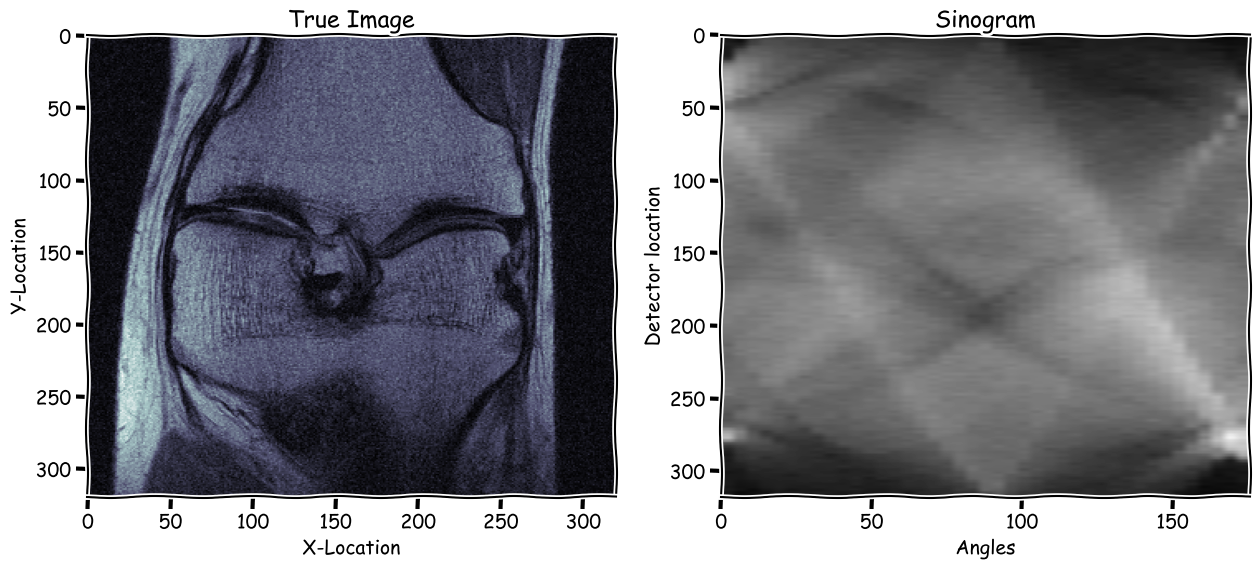

In [5]:
with plt.xkcd():
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))
    axs[0].imshow(data, vmin=0, vmax=1, cmap='bone')
    axs[0].set_xlabel('X-Location'), axs[0].set_ylabel('Y-Location')
    axs[0].set_title('True Image')
    axs[0].axis('tight')
    axs[1].imshow(sinogramn.T, cmap='gray', vmin=0, vmax=200, 
                  extent=(np.rad2deg(angles[0]), np.rad2deg(angles[-1]), 
                          detectors[-1], detectors[0]))
    axs[1].set_xlabel('Angles'), axs[1].set_ylabel('Detector location')
    axs[1].set_title('Sinogram')
    axs[1].axis('tight');

In [6]:
# Create a data object for the reconstruction
rec_id = astra.data2d.create('-vol', vol_geom)

# Define algorithm
cfg = astra.astra_dict('FBP')
cfg['ReconstructionDataId'] = rec_id
cfg['ProjectionDataId'] = sinogramn_id
cfg['ProjectorId'] = proj_id
alg_id = astra.algorithm.create(cfg)

# Run algorithm
astra.algorithm.run(alg_id, 1)
dfbp = astra.data2d.get(rec_id)

In [7]:
# CT linear operator
Cop = pylops.medical.CT2D((nx, ny), dxdet, nxdet, angles)

# Back-projection
dback = Cop.H @ sinogramn

# LS Inverse
D2op = pylops.Laplacian(dims=(nx, ny), edge=True, dtype=np.float64)

dinv = pylops.optimization.leastsquares.regularized_inversion(
    Cop, sinogramn.ravel(), [D2op], epsRs=[3e0], **dict(iter_lim=50)
)[0]
dinv = dinv.reshape(nx, ny)

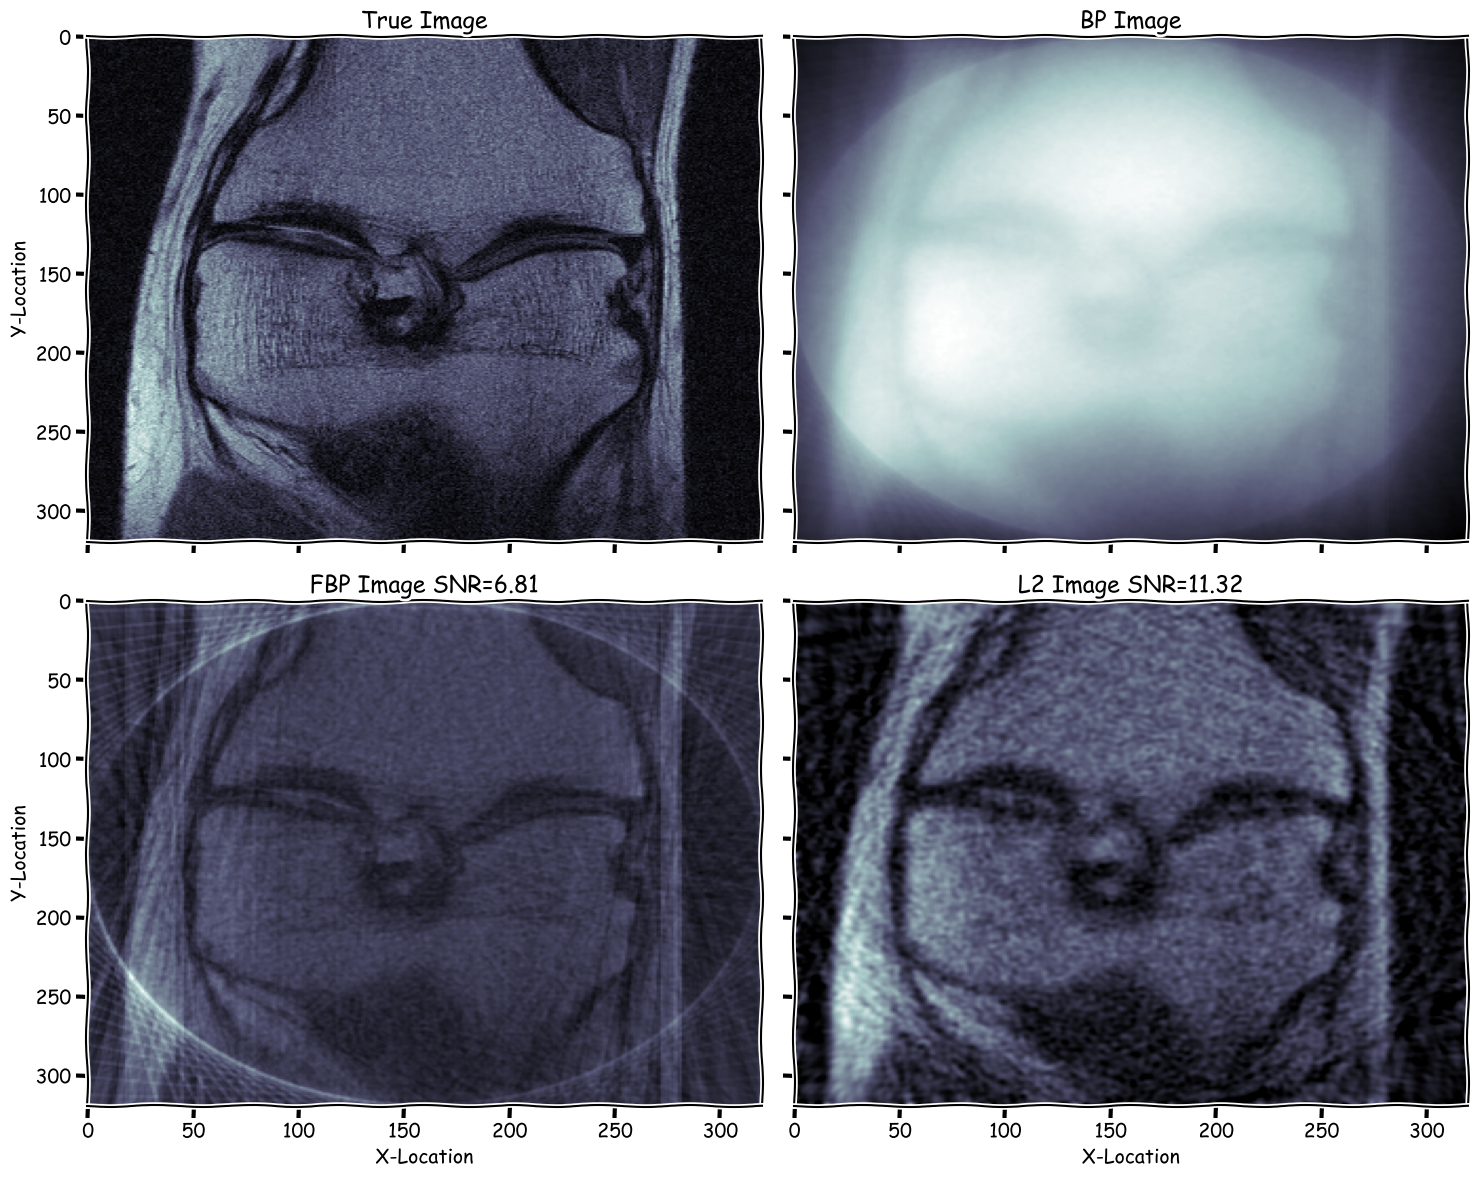

In [8]:
with plt.xkcd():
    fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(15, 12))
    axs = axs.flatten()
    axs[0].imshow(data, vmin=0, vmax=1, cmap='bone')
    axs[0].set_ylabel('Y-Location'), axs[0].set_title('True Image')
    axs[0].axis('tight')
    axs[1].imshow(dback, cmap='bone')
    axs[1].axis('tight')
    axs[1].set_title('BP Image')
    axs[2].imshow(dfbp, cmap='bone')
    axs[2].axis('tight')
    axs[2].set_xlabel('X-Location'), axs[2].set_ylabel('Y-Location')
    axs[2].set_title(f'FBP Image SNR={pylops.utils.metrics.snr(data, dfbp):.2f}')
    axs[3].imshow(dinv, vmin=0, vmax=1, cmap='bone')
    axs[3].axis('tight')
    axs[3].set_xlabel('X-Location')
    axs[3].set_title(f'L2 Image SNR={pylops.utils.metrics.snr(data, dinv):.2f}')
    plt.tight_layout();

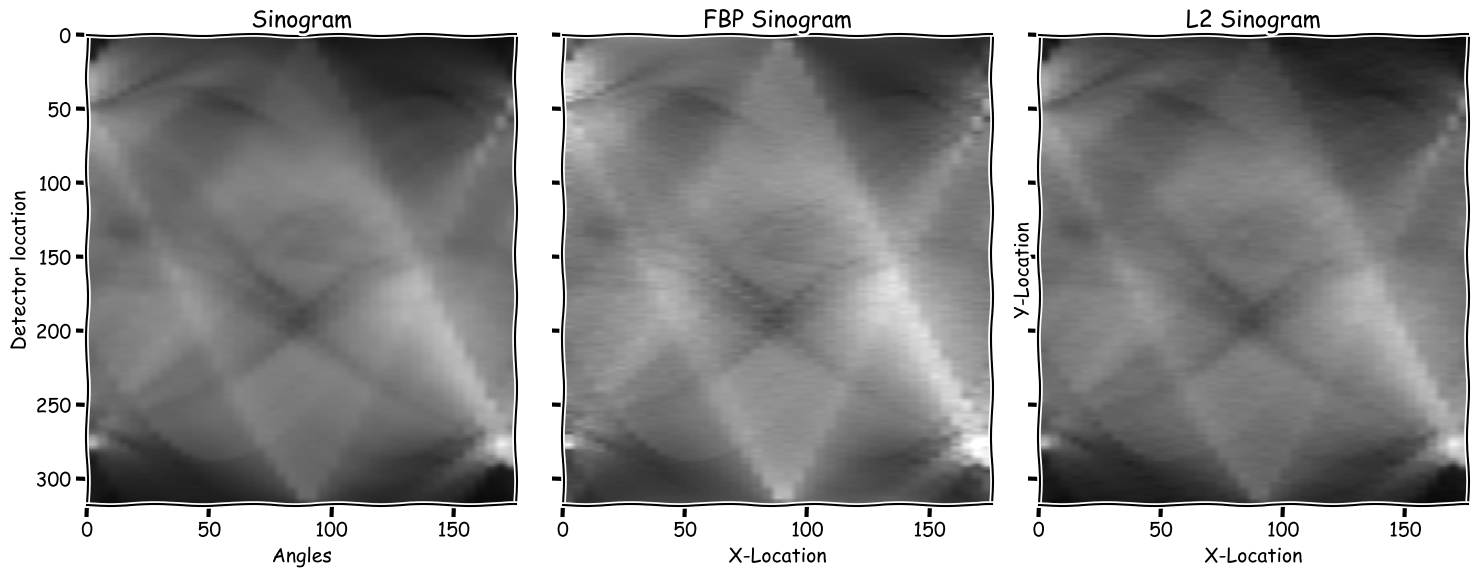

In [9]:
with plt.xkcd():
    fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15, 6))
    axs[0].imshow(sinogram.T, cmap='gray', vmin=0, vmax=200,  
                  extent=(np.rad2deg(angles[0]), np.rad2deg(angles[-1]), 
                          detectors[-1], detectors[0]))
    axs[0].set_xlabel('Angles'), axs[0].set_ylabel('Detector location')
    axs[0].set_title('Sinogram')
    axs[0].axis('tight')
    axs[1].imshow((Cop @ dfbp).T, cmap='gray', vmin=0, vmax=200,  
                  extent=(np.rad2deg(angles[0]), np.rad2deg(angles[-1]), 
                          detectors[-1], detectors[0]))
    axs[1].set_xlabel('X-Location'), axs[2].set_ylabel('Y-Location')
    axs[1].set_title('FBP Sinogram')
    axs[1].axis('tight')
    axs[2].imshow((Cop @ dinv).T, cmap='gray', vmin=0, vmax=200,  
                  extent=(np.rad2deg(angles[0]), np.rad2deg(angles[-1]), 
                          detectors[-1], detectors[0]))
    axs[2].axis('tight')
    axs[2].set_xlabel('X-Location'), axs[2].set_title('L2 Sinogram')
    plt.tight_layout();

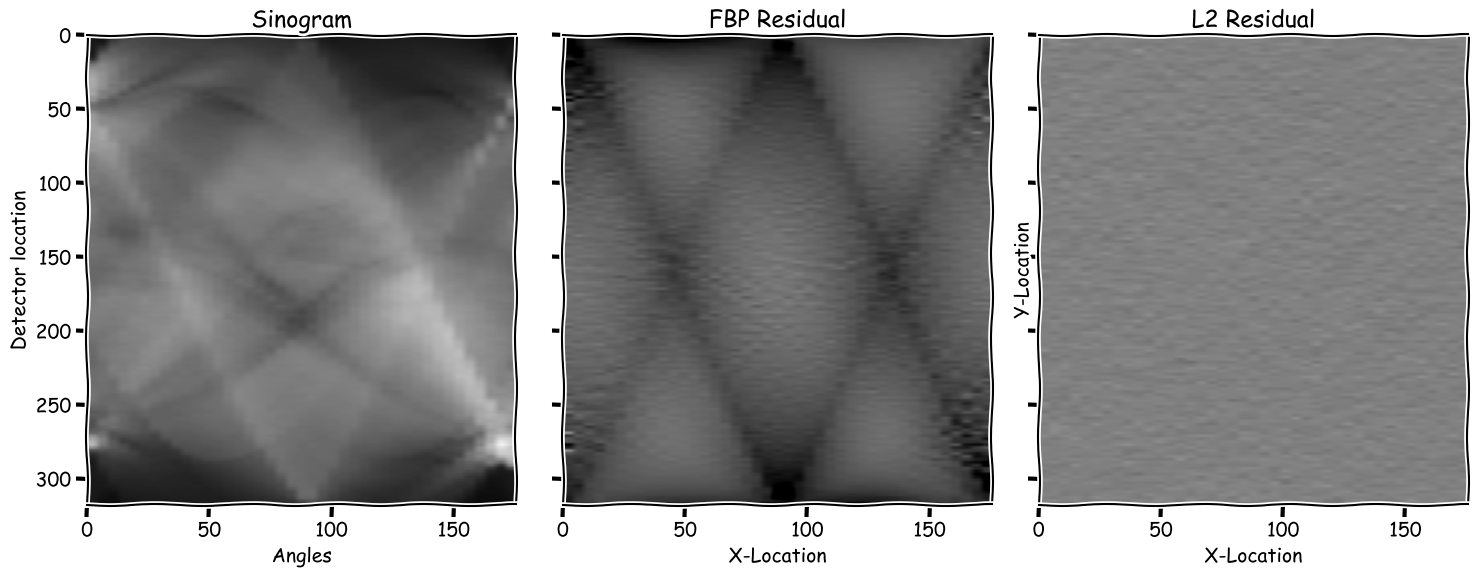

In [10]:
with plt.xkcd():
    fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15, 6))
    axs[0].imshow(sinogram.T, cmap='gray', vmin=0, vmax=200,  
                  extent=(np.rad2deg(angles[0]), np.rad2deg(angles[-1]), 
                          detectors[-1], detectors[0]))
    axs[0].set_xlabel('Angles'), axs[0].set_ylabel('Detector location')
    axs[0].set_title('Sinogram')
    axs[0].axis('tight')
    axs[1].imshow((sinogram - Cop @ dfbp).T, cmap='gray', vmin=-50, vmax=50,
                  extent=(np.rad2deg(angles[0]), np.rad2deg(angles[-1]), 
                          detectors[-1], detectors[0]))
    axs[1].set_xlabel('X-Location'), axs[2].set_ylabel('Y-Location')
    axs[1].set_title('FBP Residual')
    axs[1].axis('tight')
    axs[2].imshow((sinogram - Cop @ dinv).T, cmap='gray', vmin=-50, vmax=50,
                  extent=(np.rad2deg(angles[0]), np.rad2deg(angles[-1]), 
                          detectors[-1], detectors[0]))
    axs[2].axis('tight')
    axs[2].set_xlabel('X-Location'), axs[2].set_title('L2 Residual')
    plt.tight_layout();

## Neural network: Perceptron

<img src="../figs/Perceptron.png" width="600" align="center">

## Neural network: Multi-Layer Perceptron

<img src="../figs/MLP.png" width="600" align="center">

## Neural network: Deep Multi-Layer Perceptron

<img src="../figs/DeepMLP.png" width="600" align="center">

## Neural network: Training

Gradient descent

$$
\boldsymbol\theta_{k+1} = \boldsymbol\theta_k - \alpha_k \nabla  \mathcal{L} = \boldsymbol\theta_k - \frac{\alpha_k}{N_{train}} \sum_{i=1}^{N_{train}} \nabla \mathcal{L}^{(i)}
$$

Mini-batch gradient descent

$$
\boldsymbol\theta_{k+1} = \boldsymbol\theta_k - \alpha_k \nabla  \mathcal{L} = \boldsymbol\theta_k - \frac{\alpha_k}{N_{batch}} \sum_{i=1}^{N_{batch}} \nabla \mathcal{L}^{(i)}
$$

where:

- $\alpha_k$: learning rate
- $N_{batch}$: number of samples of a batch (i.e., random partition of the training data - $N_{batch}<<N_{train}$

## Neural network: Back-propagation

<img src="../figs/Backprop.png" width="600" align="center">

## Neural network: Back-propagation (derivation)

Let's consider the following 3 layers feed-forward NN:

$$
\textbf{z}^{[1]} = \textbf{W}^{[1]}\textbf{x} + \textbf{b}^{[1]}, \quad
\textbf{a}^{[1]} = \sigma(\textbf{z}^{[1]}),
$$

$$
\textbf{z}^{[2]} = \textbf{W}^{[2]}\textbf{a}^{[1]} + \textbf{b}^{[2]}, \quad
\textbf{a}^{[2]} = \sigma(\textbf{z}^{[2]}),
$$

$$
z^{[3]} = \textbf{w}^{[3]T}\textbf{a}^{[2]} + b^{[3]}, \quad
a^{[3]} = \sigma(z^{[3]}),
$$

followed by a generic loss $\mathcal{L}(y, a^{[3]})$. 

We would like to compute: $\partial \mathcal{L} / \partial \textbf{W}^{[2]}$ (under the assumption of sigmoid activation and binary-crossentropy loss).

## Neural network: Back-propagation (derivation)

**Backpropagation = chain rule**

$$
\frac{\partial \mathcal{L}}{\partial \mathbf{W}^{[2]}}  = \frac{\partial \textbf{z}^{[2]}}{\partial \textbf{W}^{[2]}} 
\frac{\partial \mathbf{a}^{[2]}}{\partial \mathbf{z}^{[2]}}  
\frac{\partial z^{[3]}}{\partial \mathbf{a}^{[2]}} 
\frac{\partial a^{[3]}}{\partial z^{[3]}} \frac{\partial \mathcal{L}}{\partial a^{[3]}} \\
$$

For each term in the above equation, we simply need to be able to apply the *transposed Jacobian* to a vector ($\mathbf{J}^T \mathbf{v}$).

Remember:

$$\mathbf{y} = f(\mathbf{x}) \rightarrow  \mathbf{J}  = \begin{bmatrix} 
                \frac{\partial y_1}{\partial x_1} & \frac{\partial y_1}{\partial x_2} & ... & \frac{\partial y_1}{\partial x_{N_x}} \\
                ...     & ...  & ...   & ... \\
                \frac{\partial y_{N_y}}{\partial x_1} & \frac{\partial y_{N_y}}{\partial x_2} & ... & \frac{\partial y_{N_y}}{\partial \theta_{N_x}} \\
  \end{bmatrix} \in \mathbb{R}^{[{N_y} \times {N_x}]}
$$

## Neural network: Back-propagation (derivation)

Expanding each term, we get:

$$
\frac{\partial \mathcal{L}}{\partial \mathbf{W}^{[2]}} = \begin{bmatrix}
    \mathbf{a}^{[1]}  & \mathbf{0}       &  \ldots & \mathbf{0}  \\
    \mathbf{0}        & \mathbf{a}^{[1]} &  \ldots & \mathbf{0}  \\
    \vdots            & \vdots           &  \ddots & \vdots            \\
     \mathbf{0}       & \mathbf{0}       &  \ldots & \mathbf{a}^{[1]}
\end{bmatrix} diag\{\mathbf{a}^{[2]}(1-\mathbf{a}^{[2]})\}
 \textbf{w}^{[3]} (a^{[3]} - y)
$$

## Supervised learning

**Goal:** train a network to map FBP solutions into True solutions

Given a set of brain images $M=\{\mathbf{m}^{(1)},\mathbf{m}^{(2)},..., \mathbf{m}^{(N_{train})}\}$ 

- Reconstruct FBP images: $\mathbf{d}^{(i)} = \mathcal{F}_{fbp}(\mathbf{m}^{(i)})$
- Train network: $
\underset{\theta} {\mathrm{argmin}} \; \mathcal{L}(\mathbf{M}, \mathbf{D}) + \mathcal{R}(\theta) = \underset{\theta} {\mathrm{argmin}} \; \frac{1}{N_{train}} \sum_{i=1}^{N_{train}}\mathcal{L}(\mathbf{m}^{(i)}, f_\theta(\mathbf{d}^{(i)})) + \mathcal{R}(\theta)
$
- Apply network to unseen data $\mathbf{d}$: $\hat{\mathbf{m}} = f_\theta({\mathcal{F}_{fbp}(\mathbf{m}^{(i)})})$

## Supervised learning - network architecture

Many architectures:
- Fully connected (MLP)
- Convolution
- Recurrent
- Transformer
- Invertible (Coupling Flow)
- ...
    
**Convolution** is the natural choice for gridded variables (i.e., images, volumes)

## Supervised learning - network architecture

<img src="../figs/UNet.png" width="600" align="center">

## Supervised learning

Time to practice: EX2 (ADD hyperlink)

## Deep Image Prior

Regularization vs Preconditioning

- Regularization: $\underset{\mathbf{m}} {\mathrm{argmin}} \; \mathcal{L}(\mathbf{d}, \mathbf{Gm}) + \mathcal{R}(\mathbf{m})$ (e.g., $\underset{\mathbf{m}} {\mathrm{argmin}} \; \frac{1}{2} ||\mathbf{d}-\mathbf{Gm}||_p^p + \lambda ||\mathbf{Rm}||_p^p$)

- Preconditioning: $\underset{\mathbf{z}} {\mathrm{argmin}} \; \mathcal{L}(\mathbf{d}, \mathbf{G}\mathcal{P}(\mathbf{z}))$ (e.g., $\underset{\mathbf{z}} {\mathrm{argmin}} \;\frac{1}{2} ||\mathbf{d}-\mathbf{GPz}||_p^p$)


Deep Image Prior = replace $\mathcal{P}$ with an untrained network and $\mathbf{z}$ with random noise realization

## Deep Image Prior

Deep Image Prior = replace $\mathcal{P}$ with an untrained network and $\mathbf{z}$ with random noise realization

$$
\underset{\theta} {\mathrm{argmin}} \; \mathcal{L}(\mathbf{d}, \mathbf{G}f_\theta(\mathbf{z}))
$$

**Rationale:** exploit inductive bias of network architecture (optimizer and hyperparameters)

## Deep Image Prior: Physical (linear) operators in NNs

**Challenge:** how to implement $\mathbf{G}f_\theta(\mathbf{z})$ and the associated backward?

Let's consider the following chain of operations:

$$
\mathbf{y} = f_3 \cdot f_2 \cdot f_1(\mathbf{x})
$$

where $f_3(\mathbf{x}) = \mathbf{G} \mathbf{x}$

Two routes to incorporate $f_3$ in PyTorch Autograd:

- Implement a native Pytorch operator $\rightarrow$ very time consuming (if you have lots of code already)
- Simply tell Pytorch what is the associated Jacobian.

## Deep Image Prior: Physical (linear) operators in NNs

Simply tell Pytorch what is the associated Jacobian.

Given:

$$
\mathbf{y} = \mathbf{Gx} = \begin{bmatrix}
    G_{1,1} & G_{1,2}  \\
    G_{2,1} & G_{2,2}
\end{bmatrix} \begin{bmatrix} x_1 \\ x_2 \end{bmatrix} = 
\begin{bmatrix} G_{1,1} x_1 + G_{1,2} x_2 \\ G_{2,1} x_1 + G_{2,2} x_2 \end{bmatrix}
$$

the Jacobian is: 

$$
\mathbf{J} = \begin{bmatrix}
    \frac{\partial y_1}{\partial x_1}=G_{1,1} & \frac{\partial y_1}{\partial x_1}=G_{1,2}  \\
    \frac{\partial y_1}{\partial x_1}=G_{2,1} & \frac{\partial y_1}{\partial x_1}=G_{2,2}
\end{bmatrix} = \mathbf{G}
$$

so $\mathbf{J}^T \mathbf{v}=\mathbf{G}^T \mathbf{v}$ (**we need to be able to apply the adjoint of the operator to a vector**).

In [11]:
# Inserting a PyLops linear operator into Pytorch computational graph

# Create PyLops derivative operator
n = 32
Dop = pylops.FirstDerivative(dims=(n, n))
Dop_torch = pylops.TorchOperator(Dop, device='cpu')

# Forward
x = torch.ones((n, n), requires_grad=True)
y = Dop_torch.apply(x.view(-1))

# Backward
v = torch.ones(n*n)
y.backward(v, retain_graph=True)
jtv = x.grad

# Verify equivalence with Dop.H @ v
np.allclose(jtv.numpy(), Dop.H @ np.ones((n,n)))

True

## Deep Image Prior

Time to practice: EX3 (ADD hyperlink)

## Proximal algorithms

Gradient-based optimization

$$
\underset{\mathbf{m}} {\mathrm{argmin}} \quad \frac{1}{2} ||\mathbf{d} - \mathbf{Gm}||_2^2 + \alpha ||\mathbf{m}||_2^2 + \beta ||\nabla_x\mathbf{m}||_2^2 + \gamma ||\nabla_z\mathbf{m}||_2^2 \qquad \textrm{L2-regularized (linear)}
$$

and 

$$
\underset{\mathbf{m}} {\mathrm{argmin}} \quad \frac{1}{2} ||\mathbf{d} - g(\mathbf{m})||_2^2 + \alpha ||\mathbf{m}||_2^2 + \beta ||\nabla_x\mathbf{m}||_2^2 + \gamma ||\nabla_z\mathbf{m}||_2^2 \qquad \textrm{L2-regularized (nonlinear)}
$$

## Proximal algorithms

Proximal-based optimization

$$
\underset{\mathbf{m}} {\mathrm{argmin}} \quad \frac{1}{2} ||\mathbf{d} - \mathbf{Gm}||_2^2 + \alpha ||\mathbf{m}||_1 \qquad \textrm{L1-regularized / Sparse inversion}
$$

and 

$$
\underset{\mathbf{m}} {\mathrm{argmin}} \quad \frac{1}{2} ||\mathbf{d} - \mathbf{Gm}||_2^2 + \alpha ||\mathbf{M}||_* \qquad \textrm{Low-rank matrix approximation} 
$$

and 

$$
\underset{\mathbf{m}} {\mathrm{argmin}} \quad \frac{1}{2} ||\mathbf{d} - \mathbf{Gm}||_2^2 + \alpha TV(\mathbf{m}) \qquad \textrm{TV-regularized inversion} 
$$

and 

$$
\underset{\mathbf{m} \in C} {\mathrm{argmin}} \quad \frac{1}{2} ||\mathbf{d} - \mathbf{Gm}||_2^2  \qquad \textrm{Constrained inversion}
$$

and many more...

## Denoising

We want to reconstruct a blocky 1D signal from noisy measuments:
    
$$
\underset{\mathbf{m}} {\mathrm{argmin}} \quad \frac{1}{2} ||\mathbf{d} - \mathbf{m}||_2^2 + \alpha ||\nabla^2 \mathbf{m}||_2^2
$$

or 

$$
\underset{\mathbf{m}} {\mathrm{argmin}} \quad \frac{1}{2} ||\mathbf{d} - \mathbf{m}||_2^2 + \alpha ||\nabla\mathbf{m}||_1
$$

In [12]:
# Proximal gradient CT reconstruction
sigma = 0.01
tv = pyproximal.TV((nx, ny), sigma=sigma, niter=20)
l2 = pyproximal.L2(Cop, b=sinogram.ravel(), niter=20)

L = np.real((Cop.H*Cop).eigs(neigs=1, which='LM')[0])
tau = 0.99 / L

dpg = pyproximal.optimization.primal.ProximalGradient(
    l2, tv, x0=np.zeros(nx*ny), tau=tau, niter=50, show=True)
dpg = dpg.reshape(nx, ny)

Accelerated Proximal Gradient
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.TV.TV'>
tau = 0.00015775425340130387	beta=5.000000e-01
epsg = 1.0	niter = 50	niterback = 100

   Itn       x[0]          f           g       J=f+eps*g
     1   1.44019e-01   5.754e+05   1.559e+00   5.754e+05
     2   1.40362e-01   3.936e+05   2.165e+00   3.936e+05
     3   1.34030e-01   2.909e+05   2.807e+00   2.909e+05
     4   1.27305e-01   2.262e+05   3.444e+00   2.262e+05
     5   1.20655e-01   1.822e+05   4.060e+00   1.822e+05
     6   1.14307e-01   1.506e+05   4.651e+00   1.506e+05
     7   1.08361e-01   1.270e+05   5.218e+00   1.270e+05
     8   1.02851e-01   1.087e+05   5.762e+00   1.087e+05
     9   9.77731e-02   9.422e+04   6.285e+00   9.423e+04
    10   9.31061e-02   8.247e+04   6.788e+00   8.248e+04
    11   8.88210e-02   7.279e+04   7.273e+00   7.279e+04
    16   7.20647e-02   4

In [13]:
# ADMM CT reconstruction
sigma=0.01
l1 = pyproximal.L21(ndim=2, sigma=sigma)
Dop = pylops.Gradient(dims=(nx, ny), edge=True, dtype=Cop.dtype, kind='forward')

L = 8. #np.real((Dop.H*Dop).eigs(neigs=1, which='LM')[0])
tau = 0.99 / L

dadmm = pyproximal.optimization.primal.ADMML2(
    l1, Cop, sinogram.ravel(), Dop, x0=np.zeros(nx*ny), tau=tau, 
    niter=20, show=True, **dict(iter_lim=20))[0]
dadmm = dadmm.reshape(nx, ny)

ADMM
---------------------------------------------------------
Proximal operator (g): <class 'pyproximal.proximal.L21.L21'>
tau = 1.237500e-01	niter = 20

   Itn       x[0]          f           g       J = f + g
     1   2.49529e-02   7.292e+00   2.269e+01   2.998e+01
     2   3.30573e-02   2.224e+00   2.322e+01   2.545e+01
     3   4.34212e-02   1.400e+00   2.312e+01   2.452e+01
     4   4.66973e-02   1.135e+00   2.290e+01   2.404e+01
     5   4.81599e-02   9.814e-01   2.273e+01   2.371e+01
     6   4.84703e-02   9.061e-01   2.254e+01   2.345e+01
     7   4.86670e-02   8.201e-01   2.239e+01   2.321e+01
     8   4.87016e-02   7.725e-01   2.224e+01   2.301e+01
     9   4.87565e-02   7.313e-01   2.211e+01   2.284e+01
    10   4.87344e-02   7.041e-01   2.199e+01   2.269e+01
    11   4.87821e-02   6.749e-01   2.188e+01   2.255e+01
    12   4.87605e-02   6.559e-01   2.177e+01   2.242e+01
    13   4.88079e-02   6.339e-01   2.167e+01   2.230e+01
    14   4.88186e-02   6.204e-01   2.157e+01   

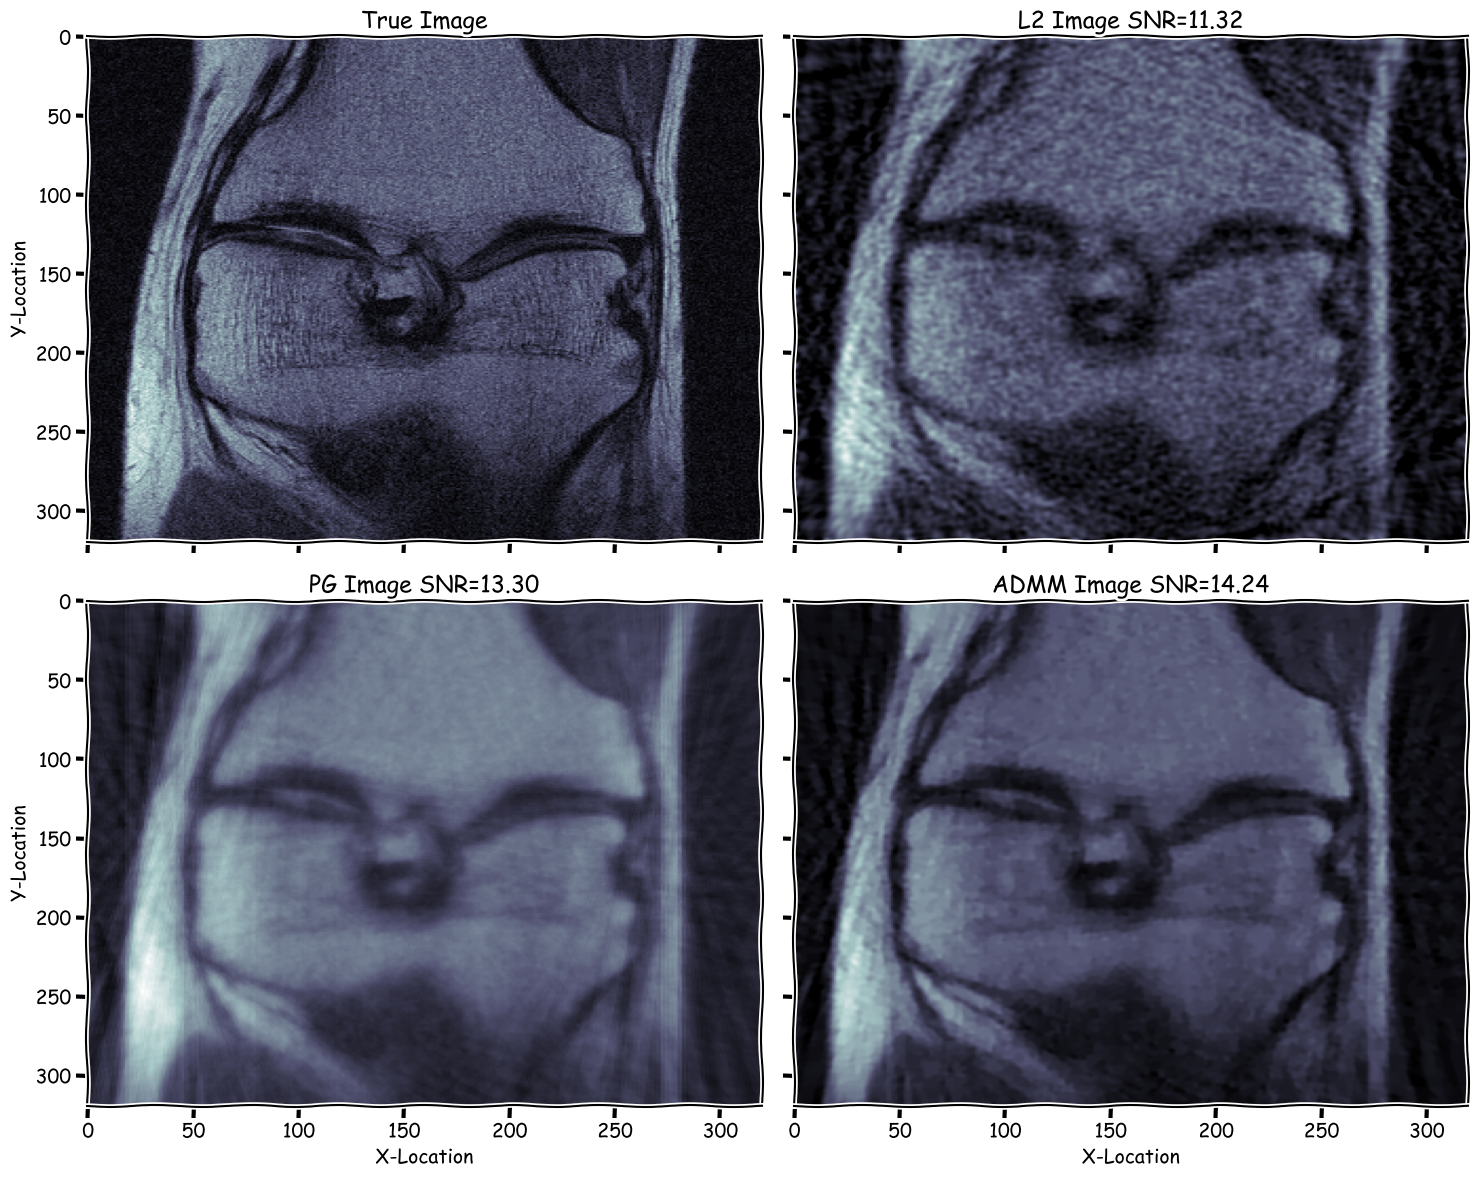

In [14]:
with plt.xkcd():
    fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(15, 12))
    axs = axs.flatten()
    axs[0].imshow(data, vmin=0, vmax=1, cmap='bone')
    axs[0].set_ylabel('Y-Location'), axs[0].set_title('True Image')
    axs[0].axis('tight')
    axs[1].imshow(dinv, vmin=0, vmax=1, cmap='bone')
    axs[1].axis('tight')
    axs[1].set_title(f'L2 Image SNR={pylops.utils.metrics.snr(data, dinv):.2f}')
    axs[2].imshow(dpg, cmap='bone')
    axs[2].axis('tight')
    axs[2].set_xlabel('X-Location'), axs[2].set_ylabel('Y-Location')
    axs[2].set_title(f'PG Image SNR={pylops.utils.metrics.snr(data, dpg):.2f}')
    axs[3].imshow(dadmm, vmin=0, vmax=1, cmap='bone')
    axs[3].axis('tight')
    axs[3].set_xlabel('X-Location')
    axs[3].set_title(f'ADMM Image SNR={pylops.utils.metrics.snr(data, dadmm):.2f}')
    plt.tight_layout();

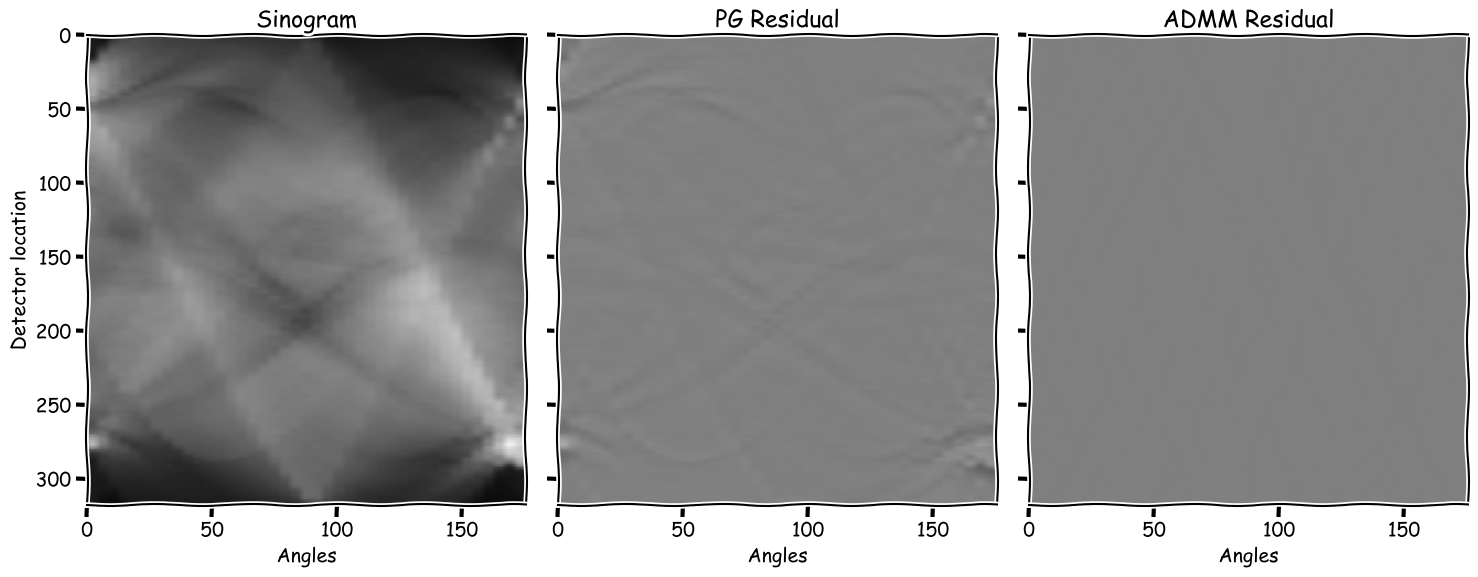

In [15]:
with plt.xkcd():
    fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15, 6))
    axs[0].imshow(sinogram.T, cmap='gray', vmin=0, vmax=200,  
                  extent=(np.rad2deg(angles[0]), np.rad2deg(angles[-1]), 
                          detectors[-1], detectors[0]))
    axs[0].set_xlabel('Angles'), axs[0].set_ylabel('Detector location')
    axs[0].set_title('Sinogram')
    axs[0].axis('tight')
    axs[1].imshow((sinogram - Cop @ dpg).T, cmap='gray', vmin=-50, vmax=50,
                  extent=(np.rad2deg(angles[0]), np.rad2deg(angles[-1]), 
                          detectors[-1], detectors[0]))
    axs[1].set_xlabel('Angles'), axs[1].set_title('PG Residual')
    axs[1].axis('tight')
    axs[2].imshow((sinogram - Cop @ dadmm).T, cmap='gray', vmin=-50, vmax=50,
                  extent=(np.rad2deg(angles[0]), np.rad2deg(angles[-1]), 
                          detectors[-1], detectors[0]))
    axs[2].axis('tight')
    axs[2].set_xlabel('Angles'), axs[2].set_title('ADMM Residual')
    plt.tight_layout();

## Proximal operator

$$
prox_{\tau f} (\mathbf{v}) = (I+ \tau \partial f)^{-1}(\mathbf{x})  = \underset{\mathbf{m}} {\mathrm{argmin}} \quad f(\mathbf{m}) + \frac{1}{2\tau}||\mathbf{m}-\mathbf{v}||_2^2
$$

<img src="../figs/ProximalOp.png" width="500" align="center">

Source: Parikh N., Proximal Algorithms.

## Proximal operator

An inverse problem at every step of the iterative scheme... bahhh!!

Luckily many proximal operators have **closed-form** solution:

$$
\text{Squared L2:} \;
prox_{\tau ||\cdot||_2^2} (\mathbf{v})  = \underset{\mathbf{m}} {\mathrm{argmin}} \quad ||\mathbf{m}||_2^2 + \frac{1}{2\tau}||\mathbf{m}-\mathbf{v}||_2^2 = \frac{\mathbf{v}}{1+\tau}
$$

$$
\text{L1:} \;prox_{\tau ||\cdot||_1} (\mathbf{v})  = \underset{\mathbf{m}} {\mathrm{argmin}} \quad ||\mathbf{m}||_1 + \frac{1}{2\tau}||\mathbf{m}-\mathbf{v}||_2^2 = soft(\mathbf{v}, \tau) \quad \text{(soft-thresholding)}
$$  

$$
\text{Box constraint:} prox_{Box_{[l, u]}} (\mathbf{v})  = \underset{\mathbf{m} \in Box} {\mathrm{argmin}} \quad  \frac{1}{2\tau}||\mathbf{m}-\mathbf{v}||_2^2 = min\{ max \{\mathbf{v}, l\}, u \}
$$ 

See Parikh N., Proximal Algorithms for an extensive list of Proximal operators.

## Optimizing mixed (smooth & non-smooth) functionals

Let's consider the case

$$
\underset{\mathbf{m}} {\mathrm{argmin}} \; \mathcal{L}(\mathbf{d}, \mathbf{Gm}) + \mathcal{R}(\mathbf{m})
$$

where $\mathcal{L}$ is a smooth function (e.g., squared L2 norm) and $\mathcal{R}$ is possibly non-smooth, convex function (e.g. L1 norm);

A smart way of solving this general problem is to use the **Forward-Backward splitting** algorithm:

$$
0 \in \nabla \mathcal{L}(\mathbf{m}) + \partial \mathcal{R}(\mathbf{m})\\
0 \in \mathbf{m}/\alpha - \mathbf{m}/\alpha + \nabla \mathcal{L}(\mathbf{m}) + \partial \mathcal{R}(\mathbf{m})\\
(I-\alpha \nabla \mathcal{R})(\mathbf{m}) \in (I+\alpha \partial \mathcal{R})(\mathbf{m})\\
\mathbf{m}_* = (I+\alpha \partial \mathcal{R})^{-1} (I-\alpha \nabla \mathcal{L})(\mathbf{m}_*)\\
\mathbf{m}_* = prox_{\alpha \mathcal{R}}(I-\alpha \nabla \mathcal{L})(\mathbf{m}_*)\\
$$

Explicit form for fixed-point iterations:

$$
\mathbf{m}_{k+1} = prox_{\alpha \mathcal{R}}(I-\alpha \nabla \mathcal{L})(\mathbf{m}_k)\\
$$

## Optimizing mixed (smooth & non-smooth) functionals

You may recognize the famous ISTA algorithm here!

When $\mathcal{L}=\frac{1}{2} ||\mathbf{d} - \mathbf{Gm}||_2^2$ and $\mathcal{R}=||\mathbf{m}||_1$, we have:

$$
\mathbf{m}_{k+1} = prox_{||\cdot||_1} (\mathbf{m}_k - \mathbf{G}^H(\mathbf{G}\mathbf{m}_k-\mathbf{d}))\\
$$

## Optimizing mixed (smooth & non-smooth) functionals

When both where $f$ and $g$ are non-smooth, convex functions, the Proximal gradient algorithm (or ISTA) cannot be used.

In order to solve this problem, a two steps procedure is required:

- Splitting: $\mathbf{y}=\mathbf{m}$, such that

$$
\underset{\mathbf{m}, \mathbf{y}} {\mathrm{argmin}} \quad f(\mathbf{m}) + g(\mathbf{y})
$$

- Augmented Lagrangian: $\text{arg} \underset{\mathbf{m},\mathbf{y}} {\mathrm{min}} \underset{\mathbf{z}}  {\mathrm{max}} \mathscr{L}$, where 
$$
\mathscr{L}=f(\mathbf{m}) + g(\mathbf{y}) + \frac{\rho}{2}||\mathbf{m}-\mathbf{y}||_2^2 + \mathbf{z}^T(\mathbf{m}-\mathbf{y})
$$

- Alternating minimization:

$$
\mathbf{m}_k = \underset{\mathbf{m}} {\mathrm{argmin}} \quad \mathscr{L}(\mathbf{m}, \mathbf{y}_{k-1}, \mathbf{z}_{k-1}) = prox_{\tau f}(\mathbf{y}_{k-1}-\mathbf{z}_{k-1}) \\
\mathbf{y}_k = \underset{\mathbf{y}} {\mathrm{argmin}} \quad \mathscr{L}(\mathbf{m}_k, \mathbf{y}, \mathbf{z}_{k-1}) = prox_{\tau g}(\mathbf{m}_k+\mathbf{z}_{k-1}) \\
\mathbf{z}_k = \underset{\mathbf{z}} {\mathrm{argmax}} \quad \mathscr{L}(\mathbf{m}_k, \mathbf{y}_k, \mathbf{z}) = \mathbf{z}_{k-1} + \mathbf{m}_k - \mathbf{y}_k
$$

This is the famous **ADMM** algorithm.

## Proximal operator - another interpretation

$$
prox_{\tau f} (\mathbf{v}) = (I+ \tau \partial f)^{-1}(\mathbf{x})  = \underset{\mathbf{m}} {\mathrm{argmin}} \; f(\mathbf{m}) + \frac{1}{2\tau}||\mathbf{m}-\mathbf{v}||_2^2
$$

**Denoising** inverse problem with data $\mathbf{v}$ and generic regularizer $f$.

## Plug-and-Play (PnP) priors

Replace proximal operator with a **denoiser of choice** (e.g., powerfull NN-based denoisers)

PnP proximal gradient:

$$
\mathbf{m}_{k+1} = Denoiser(\mathbf{m}_k - \mathbf{G}^H(\mathbf{G}\mathbf{m}_k-\mathbf{d}))\\
$$

## Plug-and-Play (PnP) priors

Time to practice: EX5 (ADD hyperlink)

## Learned iterative solvers

Gradient descent

$$
\mathbf{m}_{k+1} = f(\mathbf{m}_k,  \partial (\mathcal{L} + \mathcal{R}) / \partial \mathbf{m}; \alpha_{k})= \mathbf{m}_k - \alpha_k \frac{\partial (\mathcal{L} + \mathcal{R})}{\partial \mathbf{m}}
$$


<img src="../figs/Iterative.png" width="700" align="center">

## Learned iterative solvers

Learned Gradient descent
$$
\mathbf{m}_{k+1} = f(\mathbf{m}_k,  \partial (\mathcal{L} + \mathcal{R}) / \partial \mathbf{m}; \theta)=
\mathbf{m}_k - f_\theta\left(\frac{\partial ( \mathcal{L} + \mathcal{R})}{\partial \mathbf{m}} \right)
$$

Training: 
$$
\underset{\theta} {\mathrm{argmin}} \; \frac{1}{N_{train}} \sum_{i=1}^{N_{train}} \sum_{k=1}^{N_{it}}\mathcal{L}(\mathbf{m}^{(i)}, F_\theta(\mathbf{d}^{(i)}, \mathbf{m}_0^{(i)})|_k) + \mathcal{R}(\theta)
$$

<img src="../figs/LearnedIterative.png" width="700" align="center">

## Learned iterative solvers

Proximal gradient

$$
\mathbf{m}_{k+1} = f(\mathbf{m}_k,  \partial (\mathcal{L} + \mathcal{R}) / \partial \mathbf{m}; \alpha_{k})= prox_{\alpha \mathcal{R}} \left( \mathbf{m}_k - \alpha_k \frac{\partial (\mathcal{L} + \mathcal{R})}{\partial \mathbf{m}} \right)
$$

Learned Proximal Gradient
$$
\mathbf{m}_{k+1} = 
f_\theta \left( \mathbf{m}_k - \alpha_k \frac{\partial (\mathcal{L} + \mathcal{R})}{\partial \mathbf{m}} \right)
$$

## Learned iterative solvers

Other options inspired by classical optimizers (but not directly linked to a specific one).

- Adler and Oktem, 2017

$$
\mathbf{m}_{k+1} = \mathbf{m}_k -
f_\theta \left(\mathbf{m}_k \oplus \frac{\partial \mathcal{L}}{\partial \mathbf{m}} \oplus \frac{\partial \mathcal{R}}{\partial \mathbf{m}} \right)
$$

- Adler and Oktem, 2017 (with memory $\mathbf{s}_0 = \mathbf{0}$)

$$
\Delta \mathbf{m}_{k+1} \oplus \mathbf{s}_{k+1} = \mathbf{m}_k -
f_\theta \left(\mathbf{m}_k \oplus \mathbf{s}_k \oplus \frac{\partial \mathcal{L}}{\partial \mathbf{m}} \oplus \frac{\partial \mathcal{R}}{\partial \mathbf{m}} \right)
$$

$$
\mathbf{m}_{k+1} = \mathbf{m}_k - \Delta \mathbf{m}_{k+1} 
$$


where $\oplus$ applies concatenation.

## Summary 

Classical inversion algorithms:
    
- Gradient-based: $\underset{\mathbf{m}} {\mathrm{argmin}} \; \frac{1}{2} ||\mathbf{d} - \mathbf{Gm}||_2^2 + \mathcal{R}(\mathbf{m})$    ($\mathcal{R}$ differentiable)
    
- Proximal-based: $\underset{\mathbf{m}} {\mathrm{argmin}} \; \frac{1}{2} ||\mathbf{d} - \mathbf{Gm}||_2^2 + \mathcal{R}(\mathbf{m})$    ($\mathcal{R}$ proximable)


Zoo of deep learning-based inversion algorithms:

- Supervised learning: $
\underset{\theta} {\mathrm{argmin}} \; \frac{1}{N_{train}} \sum_{i=1}^{N_{train}}\mathcal{L}(\mathbf{m}^{(i)}, f_\theta(\mathbf{d}^{(i)})) + \mathcal{R}(\theta)$

- Deep Image prior (totally unsupervised): $
\underset{\theta} {\mathrm{argmin}} \; \frac{1}{2} ||\mathbf{d} - \mathbf{G}f_\theta(\mathbf{z})||_2^2$

- PnP prior (partially supervised): $\underset{\mathbf{m}} {\mathrm{argmin}} \; \frac{1}{2} ||\mathbf{d} - \mathbf{Gm}||_2^2 + \mathcal{R}(\mathbf{m})$    ($\mathcal{R}$ associated to a denoising algorithm)

- Learned solvers (supervised): $\underset{\mathbf{m}} {\mathrm{argmin}} \; \frac{1}{2} ||\mathbf{d} - \mathbf{Gm}||_2^2 + \mathcal{R}(\mathbf{m})$    ($\mathcal{R}$ associated to a denoising algorithm)

## Links

PyLops: 
    
- Github:
- Tutorial:

PyProximal: 
    
- Github:
- Tutorial:


ASTRA Toolbox: 
- Github:
- Tutorial:
